## GP regression ensembles with equivalent observations

Copy of `guepard' demo notebook.

This notebook illustrates how to use the equivalent observation framework to train an ensemble of Gaussian process models and to make predictions with it. First, let's load some required packages and write some plotting functionality.



In [1]:
import sys
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
import numpy as np
import guepard
import gpflow

In [2]:
import matplotlib.pyplot as plt

In [3]:
## define some plotting helper functions
def plot_mean_conf(x, mean, var, ax, color='C0'):
    ax.plot(x, mean, color, lw=2)
    ax.fill_between(
        x[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color=color,
        alpha=0.2,
    )


def plot_model(m, ax, x=np.linspace(0, 1, 101)[:, None], plot_data=True, color='C0'):
    if plot_data:
        X, Y = m.data
        ax.plot(X, Y, "kx", mew=1.)

    mean, var = m.predict_f(x)
    plot_mean_conf(x, mean, var, ax, color)


In [4]:
noise_var = 0.01


def f(x):
    return np.sin(10 * x[:, :1]) + 3. * x[:, :1]


X = np.linspace(0, 1, 101)[:, None]
Y = f(X) + np.sqrt(noise_var) * np.random.normal(size=X.shape)


[[<matplotlib.lines.Line2D at 0x177d3f820>],

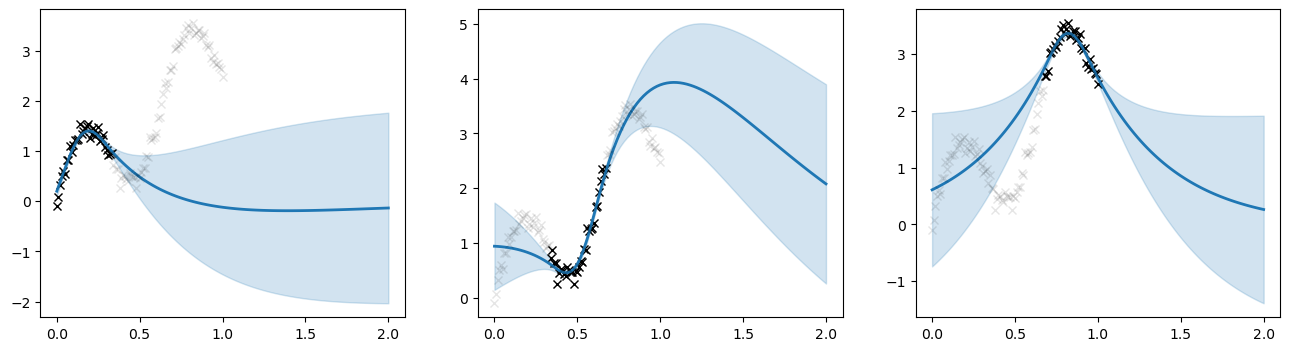

In [5]:
num_split = 3

Xl = np.array_split(X, num_split)  # list of num_split np.arrays
Yl = np.array_split(Y, num_split)

kernel = gpflow.kernels.Matern32()

# make submodels and plot them
# list of num_split GPR models
submodels = guepard.utilities.get_gpr_submodels(
    zip(Xl, Yl), kernel, noise_variance=noise_var)

# M is a list of GPR models, let's plot them
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
x = np.linspace(0, 2, 101)[:, None]
[plot_model(m, axes[i], x) for i, m in enumerate(submodels)]
[axes[i].plot(X, Y, 'kx', mew=1., alpha=.1) for i, _ in enumerate(submodels)]

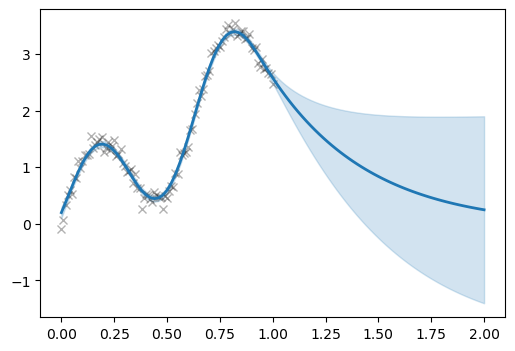

In [6]:
m_agg = guepard.EquivalentObsEnsemble(submodels)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(X, Y, 'kx', mew=1., alpha=.3)
plot_model(m_agg, ax, x, plot_data=False)


In [7]:
# Set the value of one parameter
m_agg.kernel.lengthscales.assign(0.3)

# print the model parameter summary
gpflow.utilities.print_summary(m_agg)


╒═════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ EquivalentObsEnsemble.kernel.variance               │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
│ EquivalentObsEnsemble.models[0].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[1].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[2].kernel.variance     │           │                  │         │             │         │         │         │
├────────────

## Training the GPR sub-models

Guepard models can be trained like any other GPflow model

In [8]:
m_agg.training_loss()

2023-10-09 18:34:38.561095: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


<tf.Tensor: shape=(), dtype=float64, numpy=-16.034328629454354>

In [10]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_agg.training_loss,
                        m_agg.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m_agg)

╒═════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ EquivalentObsEnsemble.kernel.variance               │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.13206 │
│ EquivalentObsEnsemble.models[0].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[1].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[2].kernel.variance     │           │                  │         │             │         │         │         │
├────────────

## Comparison with a GPR model based on the full dataset

In [11]:
# make a GPR model as baseline
m_gpr = gpflow.models.GPR((X, Y), kernel, noise_variance=noise_var)
opt_logs = opt.minimize(m_gpr.training_loss,
                        m_gpr.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m_gpr)

# Check "good" match between aggregated model and gpr at training points
mean_agg, var_agg = m_agg.predict_f(X)
mean_gpr, var_gpr = m_gpr.predict_f(X)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.07253 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.57169 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.00854 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

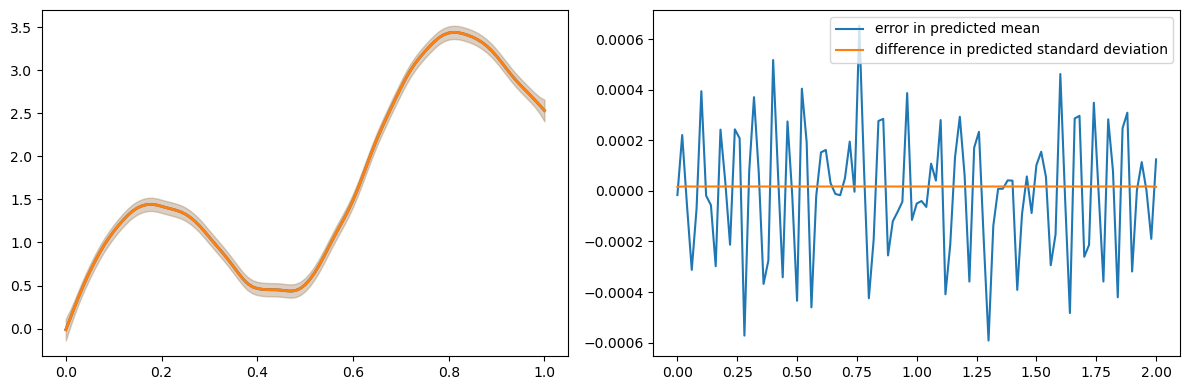

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_model(m_agg, axes[0], plot_data=False)
plot_model(m_gpr, axes[0], plot_data=False, color='C1')

axes[1].plot(x, mean_agg - mean_gpr, label="error in predicted mean")
axes[1].plot(x, np.sqrt(var_agg) - np.sqrt(var_gpr),
             label="difference in predicted standard deviation")
plt.legend()
plt.tight_layout()


## Sampling from the posterior

Since Guepard models are classic GPflow models, we can use the build in functions


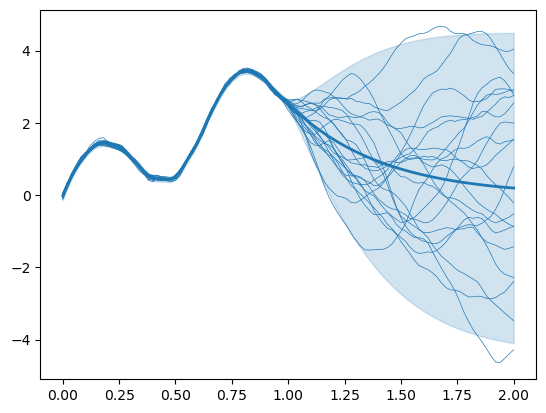

In [13]:
x = np.linspace(0, 2, 101)[:, None]
F = m_agg.predict_f_samples(x, 20).numpy()[:, :, 0]

fig, ax = plt.subplots(1, 1)
plt.plot(x, F.T, "C0", linewidth=.5)
plot_model(m_agg, ax, x, plot_data=False)


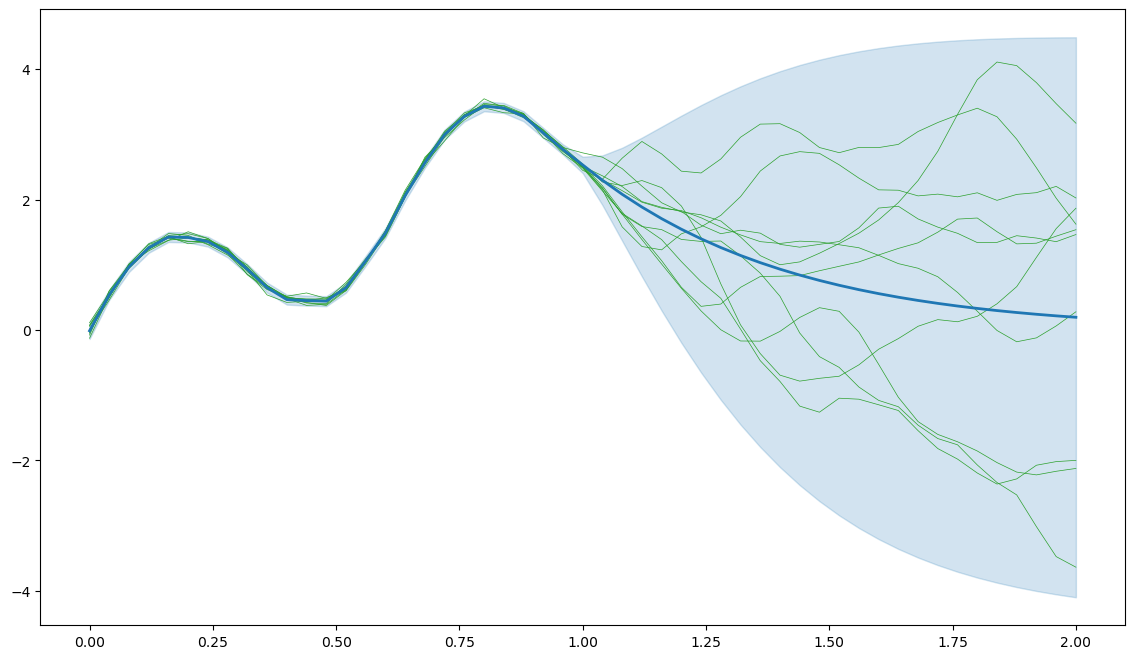

In [16]:
import tensorflow as tf
from gpflux.layers.basis_functions.fourier_features import RandomFourierFeaturesCosine

tf.keras.backend.set_floatx('float64')


class Sample:
    def __init__(self, kernel, noise_variance=0., num_rff=10000):
        self.features = RandomFourierFeaturesCosine(
            kernel, n_components=num_rff)
        self.random_weight = np.random.normal(0, 1, (num_rff, 1))
        self.noise_variance = noise_variance

    def signal(self, x):
        signal = self.features(x) @ self.random_weight
        return signal

    def __call__(self, x):
        noise = np.sqrt(self.noise_variance) * \
            np.random.normal(0, 1, (x.shape[0], 1))
        return self.signal(x) + noise


fig, ax = plt.subplots(1, 1, figsize=(14, 8))

for _ in range(10):
    x = np.linspace(0, 2, 51)[:, None]
    f = Sample(kernel)
    E = Y - f(X) + np.sqrt(noise_var) * np.random.normal(size=Y.shape)
    Es = np.array_split(E, num_split)

    # build a list of submodels of the error
    Me = guepard.utilities.get_gpr_submodels(zip(Xl, Es), kernel, noise_variance=noise_var)

    # aggregate predictions
    m_agg_error = guepard.EquivalentObsEnsemble(Me)
    m, v = m_agg_error.predict_f(x)
    ax.plot(x, f(x) + m, 'C2', lw=.5)

plot_model(m_agg, ax, x, plot_data=False)